In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import gdreg
import matplotlib.pyplot as plt
import pickle

In [2]:
N_REP = 20
DATA_PATH = '/n/groups/price/martin/data_GDREG/toy_10K'
SIMU_LIST = ["both_zero", "gene_pos", "gene_neg", "proxy_pos", "proxy_neg",
             "both_pos", "both_neg", "gene_pos_proxy_neg", "gene_neg_proxy_pos"]
DIC_SIMU = {
    x: {
        'truth' : DATA_PATH + '/trait_simu_debug/%s_rep@.eff_sum' % x,
        'res' : DATA_PATH + '/gdreg_res_simu_debug/%s_rep@' % x,
        'res_cross' : DATA_PATH + '/gdreg_res_simu_debug.cross/%s_rep@' % x,
    } 
    for x in SIMU_LIST
}

### Read results 

In [3]:
# Read results 
dic_res = {}
for simu in DIC_SIMU:
    dic_res[simu] = {}
    for i_rep in range(N_REP):
        dic_res[simu]['%d.truth'%i_rep] = pd.read_csv(
            DIC_SIMU[simu]['truth'].replace('@','%d'%i_rep), sep='\t', index_col=0
        )
        
        for res in ['res', 'res_cross']:
            for term in ["tau", "joint_tau", "joint_rho"]:
                dic_res[simu]['%d.%s.%s'%(i_rep, res, term)] = pd.read_csv(
                    DIC_SIMU[simu][res].replace('@','%d'%i_rep)+'.%s.tsv' % term, sep='\t', index_col=0
                )
            
#         for res in ["tau", "joint_tau", "joint_rho"]:
#             dic_res[simu]['%d.%s'%(i_rep, res)] = pd.read_csv(
#                 DIC_SIMU[simu]['res'].replace('@','%d'%i_rep)+'.%s.tsv' % res, sep='\t', index_col=0
#             )

### Analysis

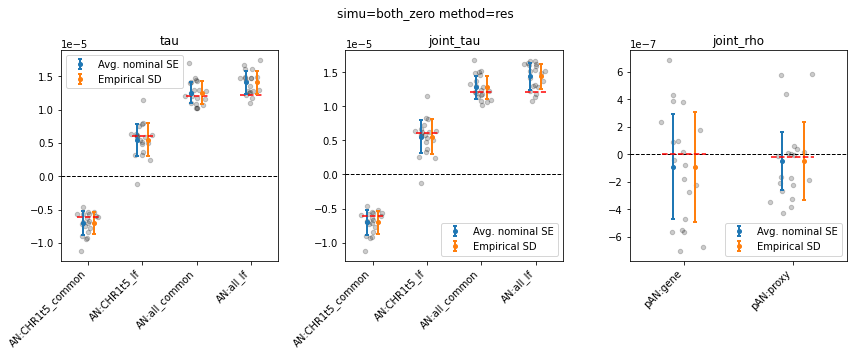

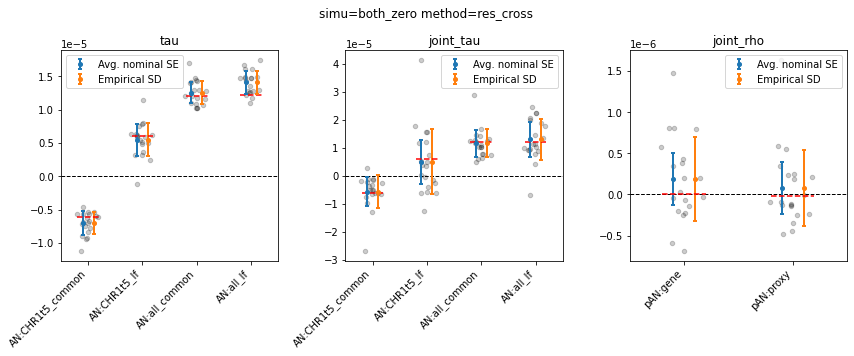

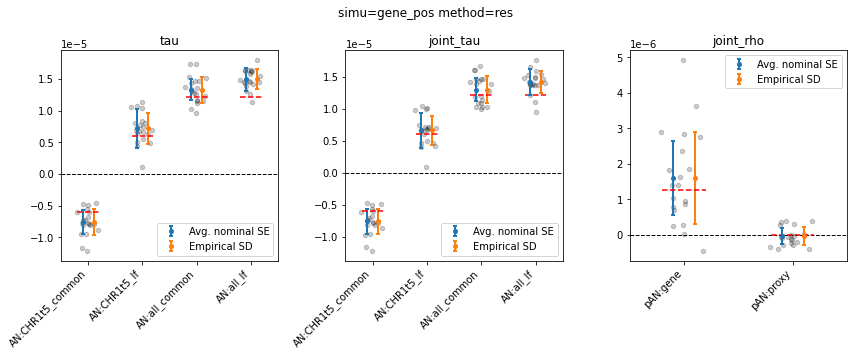

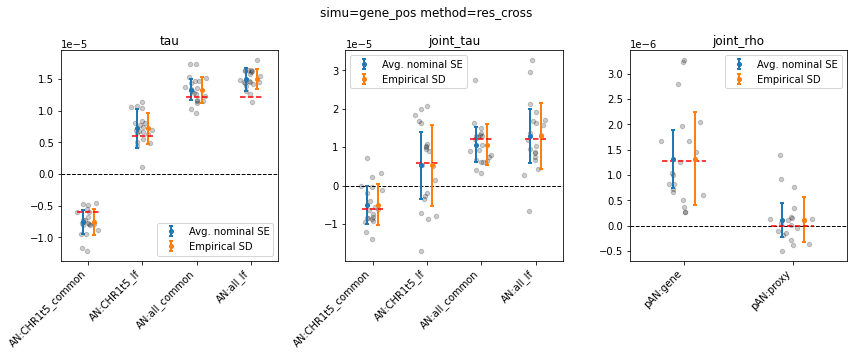

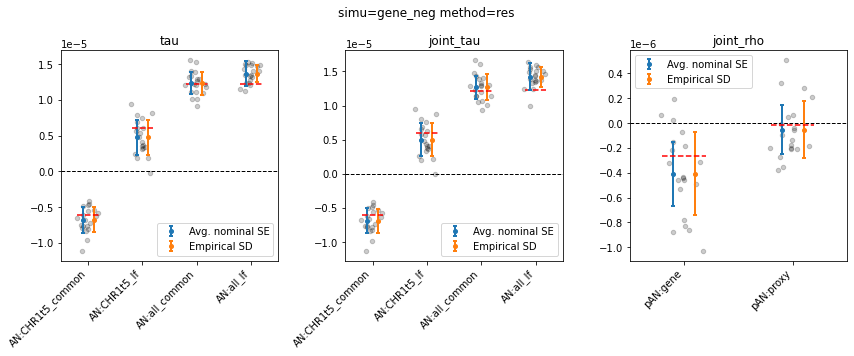

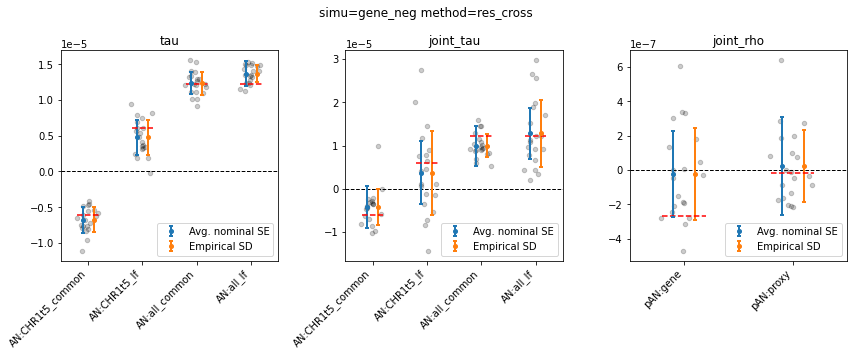

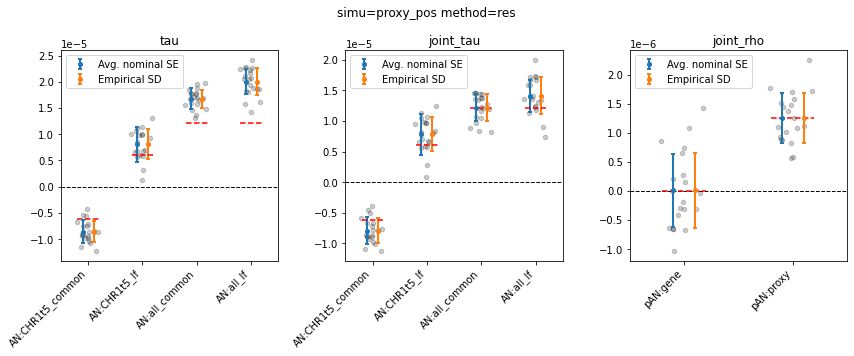

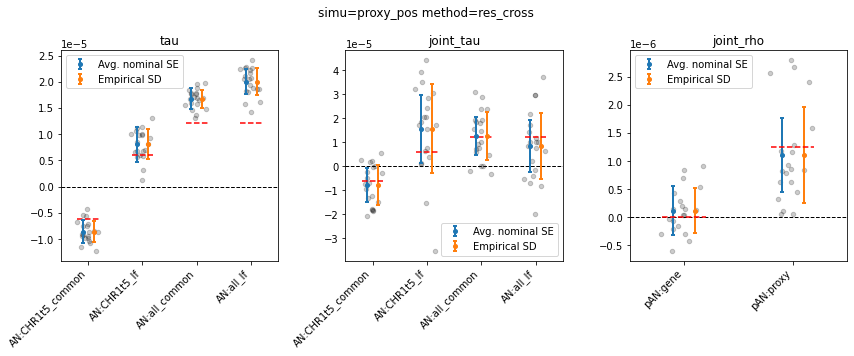

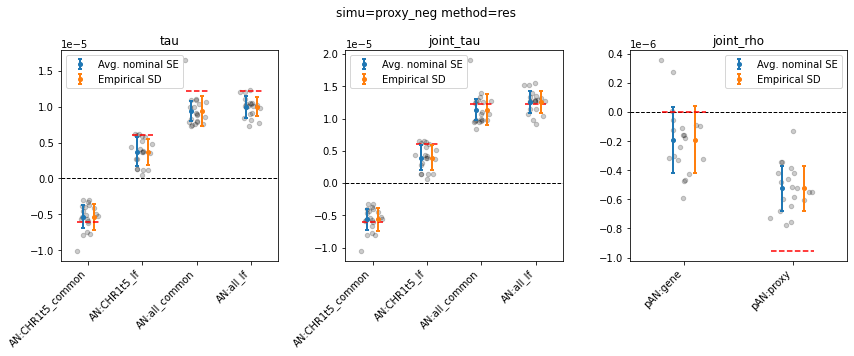

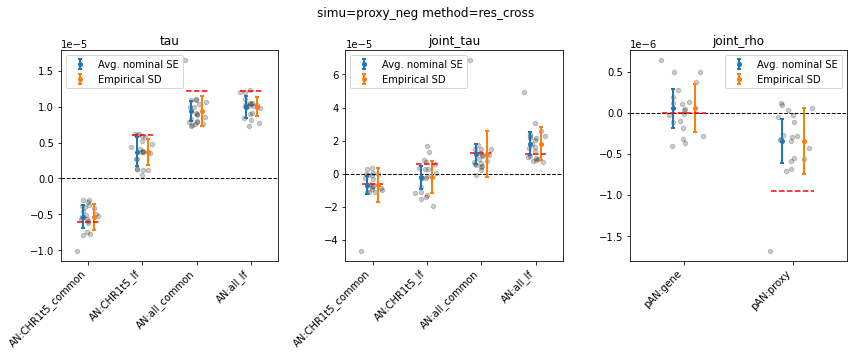

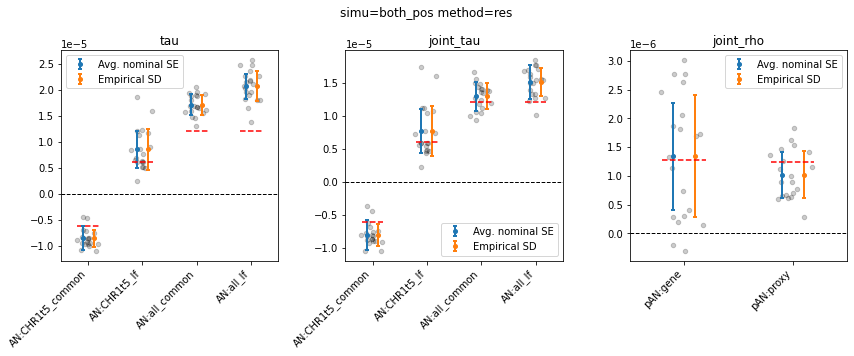

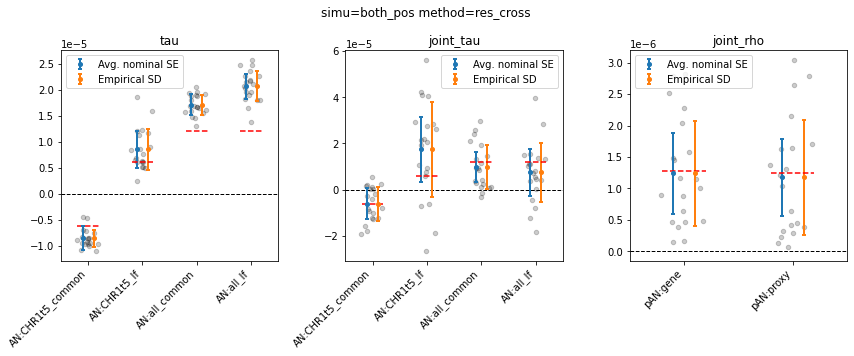

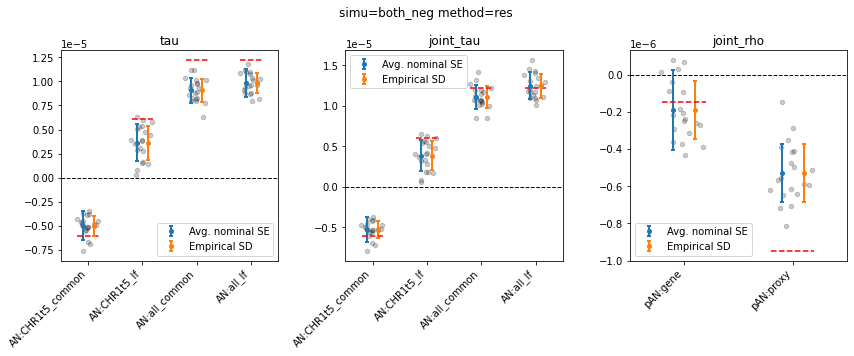

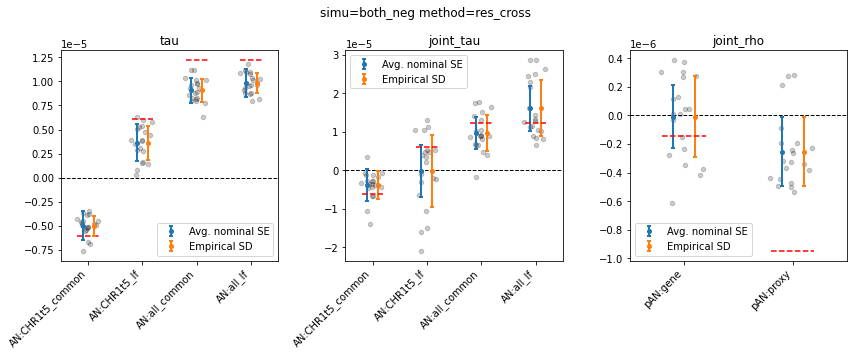

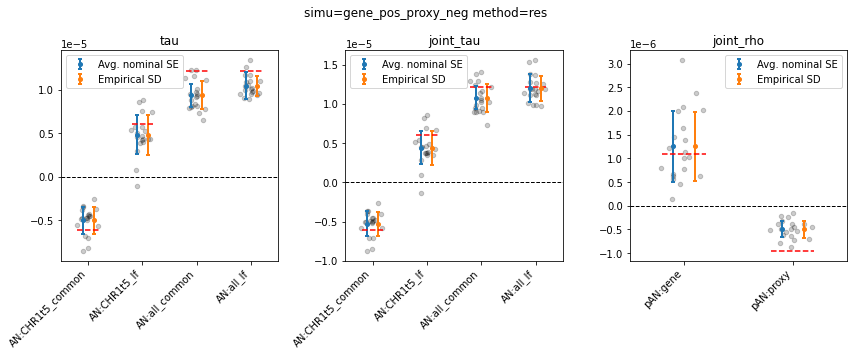

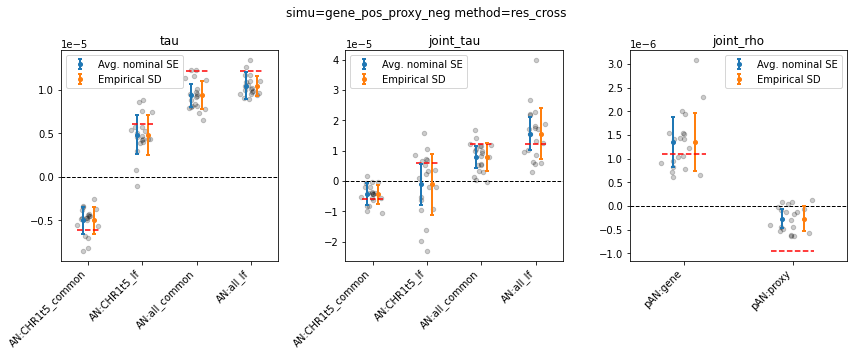

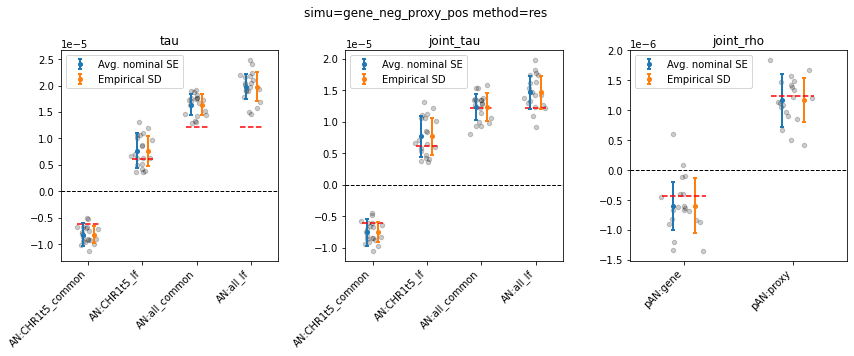

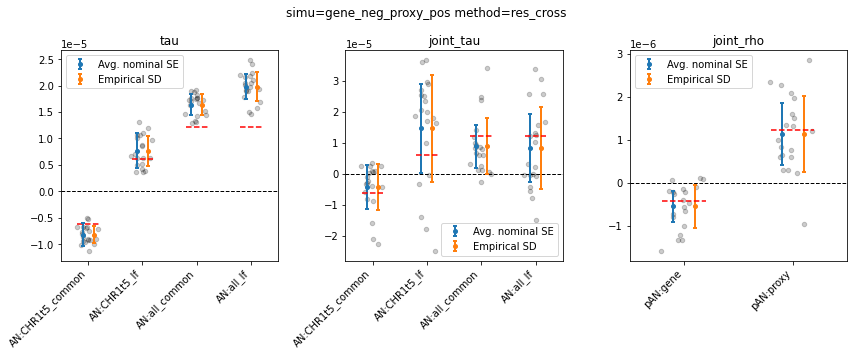

In [4]:
# Check calibration : tau
annot_list = ['AN:CHR1t5_common', 'AN:CHR1t5_lf', 'AN:all_common', 'AN:all_lf']
pannot_list = ['pAN:gene', 'pAN:proxy']
v_jitter = np.random.randn(N_REP)*0.1

for simu in SIMU_LIST:
    for res in ['res', 'res_cross']:
        plt.figure(figsize=[12,5])

        # tau
        plt.subplot(1,3,1)
        v_tau_mean = []
        v_tau_se_nom = []
        v_tau_se_empi = []
        v_tau_true_mean = []
        for i_AN,AN in enumerate(annot_list):
            v_tau = np.array([dic_res[simu]['%d.%s.tau'%(x,res)].loc[AN, 'tau'] for x in range(N_REP)])
            v_tau_se = np.array([dic_res[simu]['%d.%s.tau'%(x,res)].loc[AN, 'tau_se'] for x in range(N_REP)])
            v_tau_true = np.array([dic_res[simu]['%d.truth'%x].loc[AN, 'coef'] for x in range(N_REP)])

            v_tau_mean.append(v_tau.mean())
            v_tau_se_nom.append(v_tau_se.mean())
            v_tau_se_empi.append(v_tau.std())
            tau_true = v_tau_true.mean()

            plt.scatter(v_jitter+i_AN, v_tau, alpha=0.2, color='k', s=20)
            plt.plot([i_AN-0.2, i_AN+0.2], [tau_true, tau_true], '--', color='r', )

        # CIs
        plt.errorbar(
            np.arange(len(annot_list))-0.1, v_tau_mean, yerr=v_tau_se_nom, fmt='o', markersize=4,
            elinewidth=2, capsize=2, capthick=2, label='Avg. nominal SE'
        )
        plt.errorbar(
            np.arange(len(annot_list))+0.1, v_tau_mean, yerr=v_tau_se_empi, fmt='o', markersize=4,
            elinewidth=2, capsize=2, capthick=2, label='Empirical SD'
        )

        plt.plot([-0.5, len(annot_list)-0.5], [0, 0], '--', color='k', linewidth=1, zorder=0)
        plt.xlim([-0.5, len(annot_list)-0.5])
        plt.title('tau')
        plt.legend()
        plt.xticks(np.arange(len(annot_list)), annot_list, rotation=45, ha='right')
        
        # joint_tau
        plt.subplot(1,3,2)
        v_tau_mean = []
        v_tau_se_nom = []
        v_tau_se_empi = []
        v_tau_true_mean = []
        for i_AN,AN in enumerate(annot_list):
            v_tau = np.array([dic_res[simu]['%d.%s.joint_tau'%(x,res)].loc[AN, 'tau'] for x in range(N_REP)])
            v_tau_se = np.array(
                [dic_res[simu]['%d.%s.joint_tau'%(x,res)].loc[AN, 'tau_se'] for x in range(N_REP)])
            v_tau_true = np.array([dic_res[simu]['%d.truth'%x].loc[AN, 'coef'] for x in range(N_REP)])

            v_tau_mean.append(v_tau.mean())
            v_tau_se_nom.append(v_tau_se.mean())
            v_tau_se_empi.append(v_tau.std())
            tau_true = v_tau_true.mean()

            plt.scatter(v_jitter+i_AN, v_tau, alpha=0.2, color='k', s=20)
            plt.plot([i_AN-0.2, i_AN+0.2], [tau_true, tau_true], '--', color='r', )

        # CIs
        plt.errorbar(
            np.arange(len(annot_list))-0.1, v_tau_mean, yerr=v_tau_se_nom, fmt='o', markersize=4,
            elinewidth=2, capsize=2, capthick=2, label='Avg. nominal SE'
        )
        plt.errorbar(
            np.arange(len(annot_list))+0.1, v_tau_mean, yerr=v_tau_se_empi, fmt='o', markersize=4,
            elinewidth=2, capsize=2, capthick=2, label='Empirical SD'
        )

        plt.plot([-0.5, len(annot_list)-0.5], [0, 0], '--', color='k', linewidth=1, zorder=0)
        plt.xlim([-0.5, len(annot_list)-0.5])
        plt.title('joint_tau')
        plt.legend()
        plt.xticks(np.arange(len(annot_list)), annot_list, rotation=45, ha='right')


        # joint_rho
        plt.subplot(1,3,3)
        v_rho_mean = []
        v_rho_se_nom = []
        v_rho_se_empi = []
        v_rho_true_mean = []

        for i_pAN,pAN in enumerate(pannot_list):

            v_rho = np.array([dic_res[simu]['%d.%s.joint_rho'%(x,res)].loc[pAN, 'rho'] for x in range(N_REP)])
            v_rho_se = np.array(
                [dic_res[simu]['%d.%s.joint_rho'%(x,res)].loc[pAN, 'rho_se'] for x in range(N_REP)])
            v_rho_true = np.array([dic_res[simu]['%d.truth'%x].loc[pAN, 'coef'] for x in range(N_REP)])

            v_rho_mean.append(v_rho.mean())
            v_rho_se_nom.append(v_rho_se.mean())
            v_rho_se_empi.append(v_rho.std())
            rho_true = v_rho_true.mean()

            plt.scatter(v_jitter+i_pAN, v_rho, alpha=0.2, color='k', s=20)
            plt.plot([i_pAN-0.2, i_pAN+0.2], [rho_true, rho_true], '--', color='r', )

        # CIs
        plt.errorbar(
            np.arange(len(v_rho_mean))-0.1, v_rho_mean, yerr=v_rho_se_nom, fmt='o', markersize=4,
            elinewidth=2, capsize=2, capthick=2, label='Avg. nominal SE'
        )
        plt.errorbar(
            np.arange(len(v_rho_mean))+0.1, v_rho_mean, yerr=v_rho_se_empi, fmt='o', markersize=4,
            elinewidth=2, capsize=2, capthick=2, label='Empirical SD'
        )

        plt.plot([-0.5, len(pannot_list)-0.5], [0, 0], '--', color='k', linewidth=1, zorder=0)
        plt.xlim([-0.5, len(pannot_list)-0.5])
        plt.title('joint_rho')
        plt.legend()
        plt.xticks(np.arange(len(pannot_list)), pannot_list, rotation=45, ha='right')

        plt.suptitle("simu=%s method=%s" % (simu, res))
        plt.tight_layout()
        plt.show()

### Old code

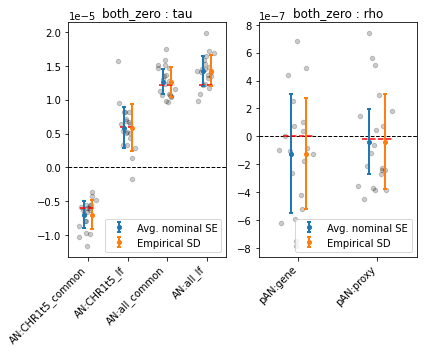

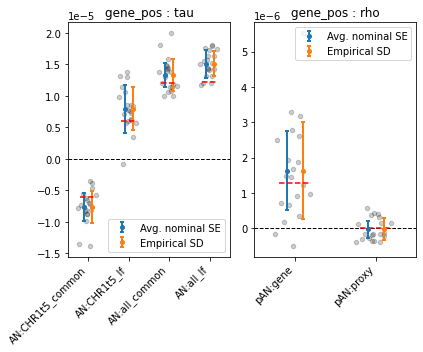

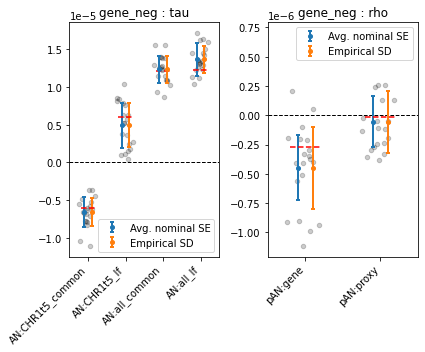

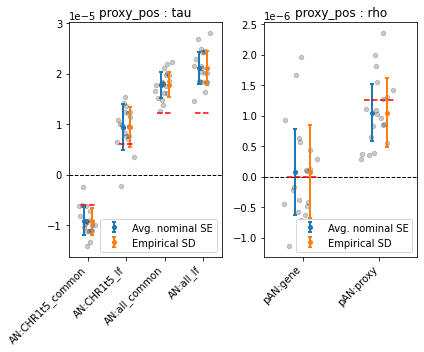

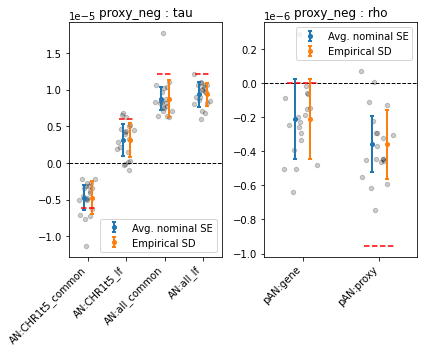

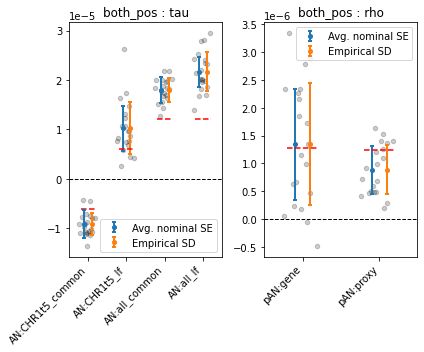

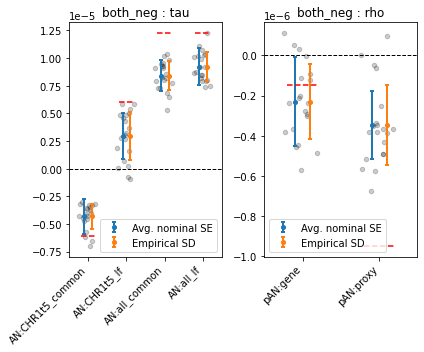

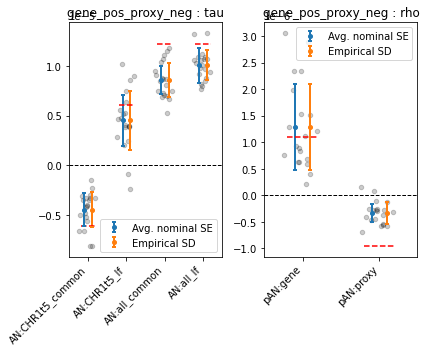

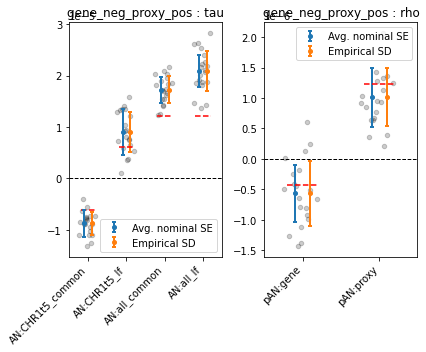

In [4]:
# Check calibration : tau
annot_list = ['AN:CHR1t5_common', 'AN:CHR1t5_lf', 'AN:all_common', 'AN:all_lf']
pannot_list = ['pAN:gene', 'pAN:proxy']
v_jitter = np.random.randn(N_REP)*0.1

for simu in SIMU_LIST:
    plt.figure(figsize=[6,5])
    
    # tau
    plt.subplot(1,2,1)
    v_tau_mean = []
    v_tau_se_nom = []
    v_tau_se_empi = []
    v_tau_true_mean = []
    for i_AN,AN in enumerate(annot_list):
        v_tau = np.array([dic_res[simu]['%d.tau'%x].loc[AN, 'tau'] for x in range(N_REP)])
        v_tau_se = np.array([dic_res[simu]['%d.tau'%x].loc[AN, 'tau_se'] for x in range(N_REP)])
        v_tau_true = np.array([dic_res[simu]['%d.truth'%x].loc[AN, 'coef'] for x in range(N_REP)])
        
        v_tau_mean.append(v_tau.mean())
        v_tau_se_nom.append(v_tau_se.mean())
        v_tau_se_empi.append(v_tau.std())
        tau_true = v_tau_true.mean()

        plt.scatter(v_jitter+i_AN, v_tau, alpha=0.2, color='k', s=20)
        plt.plot([i_AN-0.2, i_AN+0.2], [tau_true, tau_true], '--', color='r', )
        
    # CIs
    plt.errorbar(
        np.arange(len(annot_list))-0.1, v_tau_mean, yerr=v_tau_se_nom, fmt='o', markersize=4,
        elinewidth=2, capsize=2, capthick=2, label='Avg. nominal SE'
    )
    plt.errorbar(
        np.arange(len(annot_list))+0.1, v_tau_mean, yerr=v_tau_se_empi, fmt='o', markersize=4,
        elinewidth=2, capsize=2, capthick=2, label='Empirical SD'
    )
    
    plt.plot([-0.5, len(annot_list)-0.5], [0, 0], '--', color='k', linewidth=1, zorder=0)
    plt.xlim([-0.5, len(annot_list)-0.5])
    plt.title('%s : tau' % simu)
    plt.legend()
    plt.xticks(np.arange(len(annot_list)), annot_list, rotation=45, ha='right')
    
    # rho
    plt.subplot(1,2,2)
    v_rho_mean = []
    v_rho_se_nom = []
    v_rho_se_empi = []
    v_rho_true_mean = []
        
    for i_pAN,pAN in enumerate(pannot_list):
        
        v_rho = np.array([dic_res[simu]['%d.joint_rho'%x].loc[pAN, 'rho'] for x in range(N_REP)])
        v_rho_se = np.array([dic_res[simu]['%d.joint_rho'%x].loc[pAN, 'rho_se'] for x in range(N_REP)])
        v_rho_true = np.array([dic_res[simu]['%d.truth'%x].loc[pAN, 'coef'] for x in range(N_REP)])

        v_rho_mean.append(v_rho.mean())
        v_rho_se_nom.append(v_rho_se.mean())
        v_rho_se_empi.append(v_rho.std())
        rho_true = v_rho_true.mean()

        plt.scatter(v_jitter+i_pAN, v_rho, alpha=0.2, color='k', s=20)
        plt.plot([i_pAN-0.2, i_pAN+0.2], [rho_true, rho_true], '--', color='r', )
        
    # CIs
    plt.errorbar(
        np.arange(len(v_rho_mean))-0.1, v_rho_mean, yerr=v_rho_se_nom, fmt='o', markersize=4,
        elinewidth=2, capsize=2, capthick=2, label='Avg. nominal SE'
    )
    plt.errorbar(
        np.arange(len(v_rho_mean))+0.1, v_rho_mean, yerr=v_rho_se_empi, fmt='o', markersize=4,
        elinewidth=2, capsize=2, capthick=2, label='Empirical SD'
    )
    
    plt.plot([-0.5, len(pannot_list)-0.5], [0, 0], '--', color='k', linewidth=1, zorder=0)
    plt.xlim([-0.5, len(pannot_list)-0.5])
    plt.title('%s : rho' % simu)
    plt.legend()
    plt.xticks(np.arange(len(pannot_list)), pannot_list, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
#     break
